# <center> CNN-RNN Deep Learning Model</center>

## 0. Importing Libraries

In [1]:
!python --version

import warnings
warnings.filterwarnings('ignore')

Python 3.6.10 :: Anaconda, Inc.


In [2]:
import numpy as np 
import pandas as pd

import os
import math
import matplotlib.pyplot as plt

import keras
from keras.utils import np_utils
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.resnet50 import ResNet50
from keras.layers import Input, Dense, GlobalAveragePooling2D, Dense, LSTM, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.optimizers import SGD, Adam
from keras import backend as K

from sklearn.model_selection import train_test_split  
from functools import partial

%matplotlib inline
np.random.seed(7)

Using TensorFlow backend.


## 1. Loading Training Data

In [3]:
images = np.load('../data/numpy_data/images.npy', allow_pickle=True)
print(images.shape)
print(images[0].shape)

(5667,)
(32, 224, 224, 3)


In [3]:
labels = np.load('../data/numpy_data/one_hot_labels.npy', allow_pickle=True)
print(labels.shape)

(5667, 6)


In [4]:
indexes = np.load('../data/numpy_data/sample_indexes.npy', allow_pickle=True)
print(indexes.shape)

(1133,)


In [5]:
plays = np.load('../data/numpy_data/plays.npy', allow_pickle=True)
print(plays.shape)

(5667,)


In [71]:
# Code to obtain the indexes of plays from the 2017 season (very low quality) as part of our optimizations

plays_df = pd.DataFrame(data=plays).apply(lambda x: x.str[:4])
idx_2017 = plays_df[plays_df[0].isin(['6016','6017'])].index

# Removing those plays form the labels array

labels_df = pd.DataFrame(data=labels)
labels_df[4][labels_df[5] == 1.0] = 1.0
del labels_df[5]
labels = labels_df.to_numpy()
labels = labels[[i for i in range(len(plays)) if i not in idx_2017]]
labels.shape

(5465, 5)

## 2. Building the CNN using Transfer Learning

In [7]:
# VGG16

vgg16_model = VGG16(weights='imagenet')
vgg16_extractor = Model(inputs = vgg16_model.input,
              outputs = vgg16_model.get_layer('fc2').output)

In [8]:
# ResNet50

resnet_model = ResNet50(weights='imagenet')
resnet_extractor = Model(inputs = resnet_model.input,
              outputs = resnet_model.get_layer('avg_pool').output)

## 3. Extracting feature vectors for each frame

### 3.1 VGG16

In [20]:
vgg16_cnn_images = []
video_num = 1

for play in images:
    if video_num % 500 == 0 or video_num == len(images) or video_num == 1:
        print("Video " + str(video_num) + " of " + str(len(images)))
    vgg16_cnn_images.append(vgg16_extractor.predict(play))
    video_num += 1
    
vgg16_cnn_images = np.asarray(vgg16_cnn_images)

Video 1 of 5667
Video 500 of 5667
Video 1000 of 5667
Video 1500 of 5667
Video 2000 of 5667
Video 2500 of 5667
Video 3000 of 5667
Video 3500 of 5667
Video 4000 of 5667
Video 4500 of 5667
Video 5000 of 5667
Video 5500 of 5667
Video 5667 of 5667


In [ ]:
print(vgg16_cnn_images.shape)
print(vgg16_cnn_images[0].shape)

In [9]:
# Saving the numpy array containing all the frames for each play as 4096-long featrue vectors outputed by VGG16

np.save('../data/numpy_data/vgg16_cnn_images.npy', vgg16_cnn_images)

In [38]:
vgg16_cnn_images = np.load('../data/numpy_data/vgg16_cnn_images.npy', allow_pickle=True)
print(vgg16_cnn_images.shape)
print(vgg16_cnn_images[0].shape)

(5667,)
(32, 4096)


### 3.1 ResNet50

In [22]:
resnet_cnn_images = []
video_num = 1

for play in images:
    if video_num % 500 == 0 or video_num == len(images) or video_num == 1:
        print("Video " + str(video_num) + " of " + str(len(images)))
    #resnet_cnn_images.append(resnet_extractor.predict(play))
    video_num += 1
    
resnet_cnn_images = np.asarray(resnet_cnn_images)

Video 1 of 5667
Video 500 of 5667
Video 1000 of 5667
Video 1500 of 5667
Video 2000 of 5667
Video 2500 of 5667
Video 3000 of 5667
Video 3500 of 5667
Video 4000 of 5667
Video 4500 of 5667
Video 5000 of 5667
Video 5500 of 5667
Video 5667 of 5667


In [11]:
print(resnet_cnn_images.shape)
print(resnet_cnn_images[0].shape)

(5667,)
(32, 2048)


In [50]:
# Saving the numpy array containing all the frames for each play as 4096-long featrue vectors outputed by VGG16

np.save('../data/numpy_data/resnet_cnn_images.npy', resnet_cnn_images)

In [6]:
resnet_cnn_images = np.load('../data/numpy_data/resnet_cnn_images.npy', allow_pickle=True)
print(resnet_cnn_images.shape)
print(resnet_cnn_images[0].shape)

(5667,)
(32, 2048)


In [50]:
# Removing 2017 low quality plays form the image feature vectors array

cnn_images = resnet_cnn_images[[i for i in range(len(plays)) if i not in idx_2017]]
cnn_images.shape

(5667,)

## 4. Building the LSTM Network

In [15]:
train_idx = np.random.choice(len(cnn_images), size=int(len(cnn_images) * 0.8), replace=False)
test_idx = list(set(train_idx) ^ set([x for x in range(len(cnn_images))]))

In [16]:
X_train = resnet_cnn_images[train_idx]
X_test = resnet_cnn_images[test_idx]

y_train = labels[train_idx]
y_test = labels[test_idx]

In [17]:
X_train_pad = sequence.pad_sequences(X_train, maxlen=30)
X_test_pad = sequence.pad_sequences(X_test, maxlen=30)

In [12]:
# First LSTM Architecture (Not Being Used Anymore)
model = Sequential()
model.add(LSTM(200, return_sequences=False,input_shape=(15, 2048)))
model.add(Dense(6, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=6, batch_size=32)
print(model.summary())

In [241]:
# Second LSTM Architecture
model = Sequential()
model.add(LSTM(64, return_sequences=True,input_shape=(30, 2048)))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64)) 
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=8, batch_size=32)
print(model.summary())

Train on 4372 samples, validate on 1093 samples
Epoch 1/8
4372/4372 [==============================] - 14s 3ms/step - loss: 0.8933 - accuracy: 0.6430 - val_loss: 0.7531 - val_accuracy: 0.7219
Epoch 2/8
4372/4372 [==============================] - 12s 3ms/step - loss: 0.6501 - accuracy: 0.7571 - val_loss: 0.6124 - val_accuracy: 0.7685
Epoch 3/8
4372/4372 [==============================] - 11s 3ms/step - loss: 0.5952 - accuracy: 0.7827 - val_loss: 0.5336 - val_accuracy: 0.8106
Epoch 4/8
4372/4372 [==============================] - 11s 2ms/step - loss: 0.5191 - accuracy: 0.8150 - val_loss: 0.5192 - val_accuracy: 0.8152
Epoch 5/8
4372/4372 [==============================] - 11s 3ms/step - loss: 0.4529 - accuracy: 0.8474 - val_loss: 0.5372 - val_accuracy: 0.7978
Epoch 6/8
4372/4372 [==============================] - 12s 3ms/step - loss: 0.4221 - accuracy: 0.8614 - val_loss: 0.5088 - val_accuracy: 0.8106
Epoch 7/8
4372/4372 [==============================] - 11s 2ms/step - loss: 0.3804 - acc

In [248]:
# Checking results for specific classes

#types = ['K', 'R', 'P', 'X', 'F', 'U']
types = ['K', 'R', 'P', 'X/F', 'U']
corrects =  [0.0 for _ in range(len(types))]
counts = [0.0 for _ in range(len(types))]


for idx in range(len(y_test)):
    counts[np.argmax(y_test[idx])] += 1.0
    pred = model.predict(X_test_pad[idx:idx+1])
    if np.argmax(y_test[idx]) == np.argmax(pred):
            corrects[np.argmax(y_test[idx])] += 1.0

print("Total Accuracy: %.2f%%" % (scores[1]*100))
for i in range(len(types)):
    print(types[i] + " Accuracy: %.2f%%" % (100 * corrects[i]/counts[i]))

Total Accuracy: 83.90%
K Accuracy: 83.58%
R Accuracy: 87.95%
P Accuracy: 81.82%
X/F Accuracy: 89.47%
U Accuracy: 55.56%


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


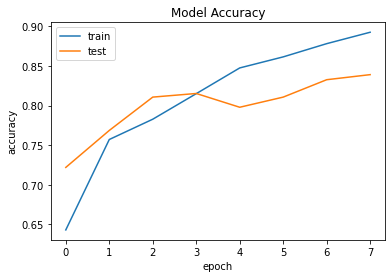

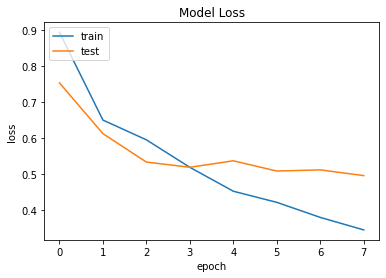

In [249]:
# Plotting Accuracy and Loss

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
# Calculating averatge prediction time:
import time

total_time = 0

for idx in range(len(y_test)):
    start = time.time()
    pred = model.predict(X_test_pad[idx:idx+1])
    total_time += (time.time() - start)
print(1000*(total_time/(idx+1)))

7.321953729023638


In [13]:
# Checking results for specific classes

# types = ['K', 'R', 'P', 'X', 'F', 'U']
types = ['K', 'R', 'P', 'X/F', 'U']
correct = 0
count = 0

for idx in range(len(y_test)):
    if types[np.argmax(y_test[idx])] == 'U':
        count += 1
        pred = model.predict(X_test_pad[idx:idx+1])
        print("Play Type: " + types[np.argmax(pred)])
        print("Actual Type: " + types[np.argmax(y_test[idx])])
        print("Play: " + str(plays[test_idx[idx]]))
        print()
        if np.argmax(y_test[idx]) == np.argmax(pred):
            correct += 1
acc = (correct/count) * 100
print("Test Accuracy: %.2f%%" % acc)

In [250]:
# Saving Model
model.save('cnn_rnn_model_final.h5')